# Dataset Gallery

This notebook demonstrates all **22 supported datasets** in StatPhys-ML package.

All datasets follow the scaling convention: $z = \frac{1}{\sqrt{d}} w^\top x = O(1)$

## Overview

| Category | Datasets | File |
|----------|----------|------|
| **Gaussian** | `GaussianDataset`, `GaussianClassificationDataset`, `GaussianMultiOutputDataset` | `gaussian.py` |
| **Sparse** | `SparseDataset`, `BernoulliGaussianDataset` | `sparse.py` |
| **Structured** | `StructuredDataset`, `CorrelatedGaussianDataset`, `SpikedCovarianceDataset` | `structured.py` |
| **GLM Teachers** | `LogisticTeacherDataset`, `ProbitTeacherDataset` | `glm.py` |
| **Gaussian Mixture** | `GaussianMixtureDataset`, `MulticlassGaussianMixtureDataset` | `glm.py` |
| **ICL Tasks** | `ICLLinearRegressionDataset`, `ICLNonlinearRegressionDataset` | `icl.py` |
| **Sequence/Token** | `MarkovChainDataset`, `CopyTaskDataset`, `GeneralizedPottsDataset`, `TiedLowRankAttentionDataset`, `MixedGaussianSequenceDataset` | `sequence.py` |
| **Attention** | `AttentionIndexedModelDataset` | `attention.py` |
| **Fairness** | `TeacherMixtureFairnessDataset` | `fairness.py` |
| **Noisy Labels** | `NoisyGMMSelfDistillationDataset` | `noisy.py` |

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.gridspec import GridSpec

# Import statphys
import statphys
statphys.fix_seed(42)

# Set publication-quality style
statphys.apply_paper_style()

# Additional styling
sns.set_palette("husl")

print(f"StatPhys-ML version info:")
statphys.info()

StatPhys-ML version info:
StatPhys-ML v0.1.0
Author: Yuma Ichikawa

Available modules:
  - dataset: Data generation (Gaussian, Sparse, Structured)
  - model: Learning models (Linear, Committee, MLP, Transformer)
  - loss: Loss functions (MSE, Ridge, LASSO, Hinge, Logistic)
  - theory: Theoretical calculations (Replica, Online ODEs)
  - simulation: Numerical experiments
  - vis: Visualization tools


## Helper Functions for Visualization

In [2]:
def plot_dataset_overview(X, y, title, dataset_info=None, figsize=(14, 4)):
    """
    Create a comprehensive visualization of a dataset.
    
    Args:
        X: Input data (n_samples, d)
        y: Labels/outputs (n_samples,)
        title: Dataset title
        dataset_info: Optional dict with additional info
    """
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(1, 4, figure=fig, width_ratios=[1.2, 1, 1, 1])
    
    # Convert to numpy
    X_np = X.numpy() if isinstance(X, torch.Tensor) else X
    y_np = y.numpy() if isinstance(y, torch.Tensor) else y
    
    # 1. Scatter plot of first two dimensions
    ax1 = fig.add_subplot(gs[0])
    if len(np.unique(y_np)) <= 10:  # Classification
        scatter = ax1.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='coolwarm', 
                             alpha=0.7, s=20, edgecolors='white', linewidths=0.5)
        plt.colorbar(scatter, ax=ax1, label='Label')
    else:  # Regression
        scatter = ax1.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='viridis', 
                             alpha=0.7, s=20, edgecolors='white', linewidths=0.5)
        plt.colorbar(scatter, ax=ax1, label='y')
    ax1.set_xlabel('$x_1$')
    ax1.set_ylabel('$x_2$')
    ax1.set_title('First Two Dimensions')
    
    # 2. Distribution of X (multiple components)
    ax2 = fig.add_subplot(gs[1])
    for i in range(min(5, X_np.shape[1])):
        ax2.hist(X_np[:, i], bins=30, alpha=0.5, label=f'$x_{{{i+1}}}$', density=True)
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Density')
    ax2.set_title('Input Distribution')
    ax2.legend(fontsize=8)
    
    # 3. Distribution of y
    ax3 = fig.add_subplot(gs[2])
    if len(np.unique(y_np)) <= 10:  # Classification
        unique, counts = np.unique(y_np, return_counts=True)
        colors = plt.cm.coolwarm(np.linspace(0.2, 0.8, len(unique)))
        bars = ax3.bar(unique, counts, color=colors, edgecolor='black', linewidth=0.5)
        ax3.set_xlabel('Class')
        ax3.set_ylabel('Count')
    else:  # Regression
        ax3.hist(y_np, bins=30, color='steelblue', edgecolor='white', alpha=0.8, density=True)
        ax3.set_xlabel('y')
        ax3.set_ylabel('Density')
    ax3.set_title('Output Distribution')
    
    # 4. Covariance heatmap (subsampled)
    ax4 = fig.add_subplot(gs[3])
    n_show = min(20, X_np.shape[1])
    cov_sample = np.corrcoef(X_np[:, :n_show].T)
    im = ax4.imshow(cov_sample, cmap='RdBu_r', vmin=-1, vmax=1)
    plt.colorbar(im, ax=ax4, label='Correlation')
    ax4.set_xlabel('Dimension')
    ax4.set_ylabel('Dimension')
    ax4.set_title(f'Correlation (first {n_show} dims)')
    
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig


def plot_classification_boundary(X, y, title, figsize=(6, 5)):
    """
    Plot classification data with decision boundary visualization.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    X_np = X.numpy() if isinstance(X, torch.Tensor) else X
    y_np = y.numpy() if isinstance(y, torch.Tensor) else y
    
    # Create meshgrid for background
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    
    # Plot data points
    unique_labels = np.unique(y_np)
    colors = plt.cm.coolwarm(np.linspace(0.1, 0.9, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        mask = y_np == label
        ax.scatter(X_np[mask, 0], X_np[mask, 1], 
                  c=[colors[i]], label=f'y = {int(label)}',
                  alpha=0.7, s=30, edgecolors='white', linewidths=0.5)
    
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(title)
    ax.legend()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    return fig

---

## 1. Gaussian Datasets

Standard i.i.d. Gaussian inputs with various teacher models.

### 1.1 GaussianDataset (Linear Regression)

Dataset: GaussianDataset
  - Input dimension: 100
  - Teacher norm (rho): 1.0
  - Noise variance (eta): 0.1
  - X shape: torch.Size([500, 100])
  - y range: [-2.86, 2.69]


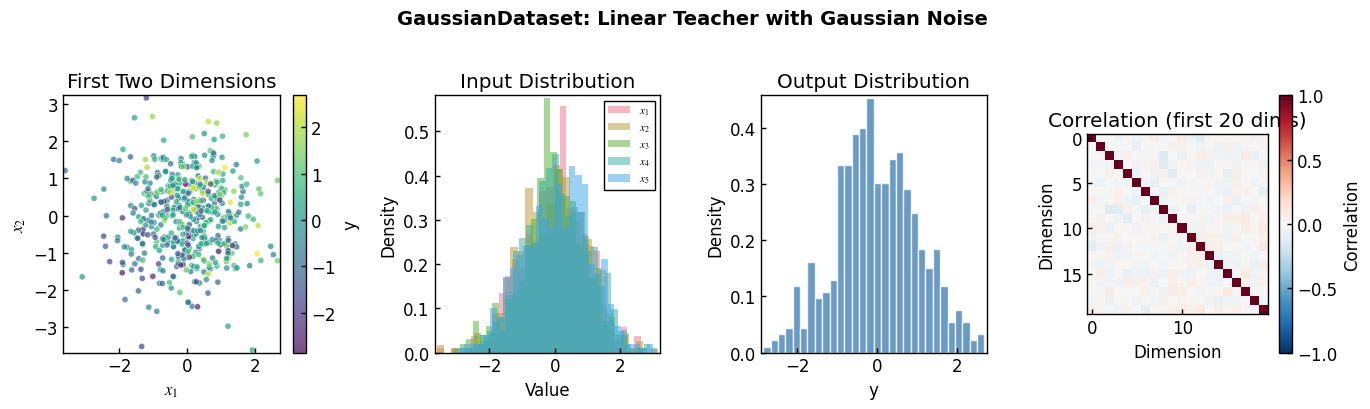

In [3]:
from statphys.dataset import GaussianDataset

# Create dataset
dataset = GaussianDataset(d=100, rho=1.0, eta=0.1)
X, y = dataset.generate_dataset(n_samples=500)

print(f"Dataset: GaussianDataset")
print(f"  - Input dimension: {dataset.d}")
print(f"  - Teacher norm (rho): {dataset.rho}")
print(f"  - Noise variance (eta): {dataset.eta}")
print(f"  - X shape: {X.shape}")
print(f"  - y range: [{y.min():.2f}, {y.max():.2f}]")

plot_dataset_overview(X, y, "GaussianDataset: Linear Teacher with Gaussian Noise")
plt.show()

### 1.2 GaussianClassificationDataset (Sign Teacher)

Dataset: GaussianClassificationDataset
  - Input dimension: 100
  - Teacher norm (rho): 1.0
  - Label flip probability: 0.0
  - Unique labels: [-1.0, 1.0]


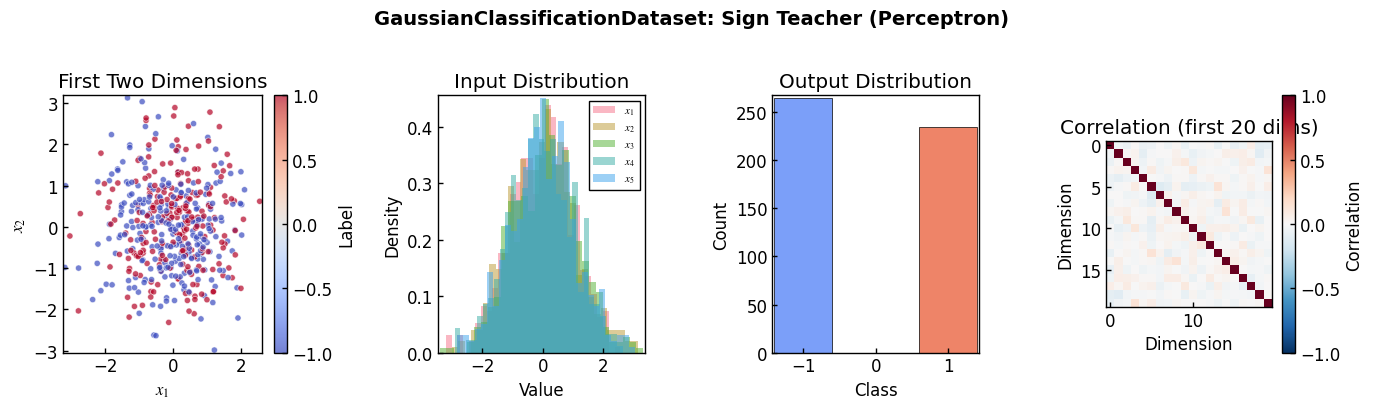

In [4]:
from statphys.dataset import GaussianClassificationDataset

# Create dataset
dataset = GaussianClassificationDataset(d=100, rho=1.0, flip_prob=0.0)
X, y = dataset.generate_dataset(n_samples=500)

print(f"Dataset: GaussianClassificationDataset")
print(f"  - Input dimension: {dataset.d}")
print(f"  - Teacher norm (rho): {dataset.rho}")
print(f"  - Label flip probability: {dataset.flip_prob}")
print(f"  - Unique labels: {torch.unique(y).tolist()}")

plot_dataset_overview(X, y, "GaussianClassificationDataset: Sign Teacher (Perceptron)")
plt.show()

### 1.3 GaussianMultiOutputDataset (Committee Teacher)

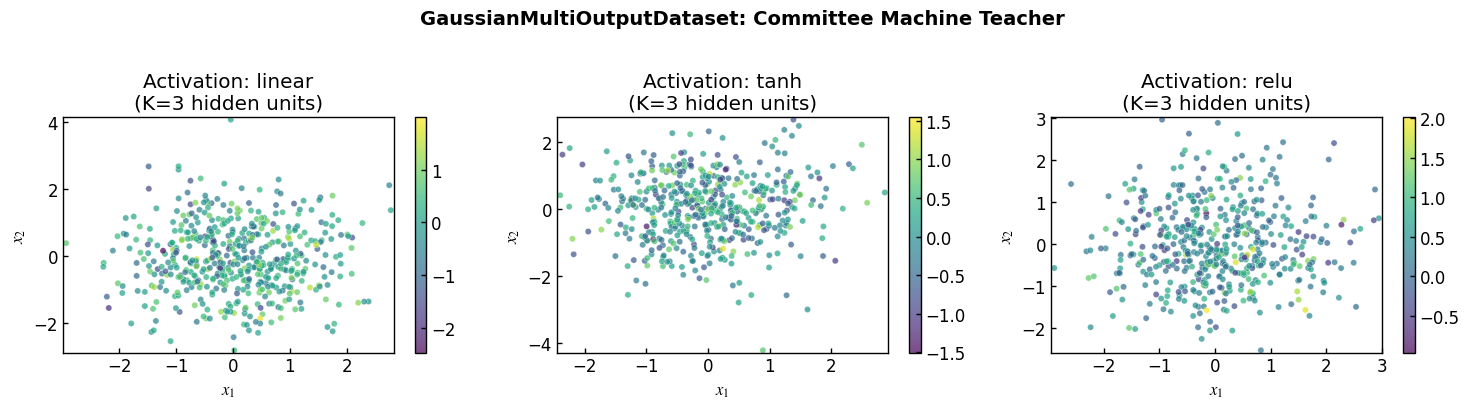

In [5]:
from statphys.dataset import GaussianMultiOutputDataset

# Create dataset with different activations
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

activations = ['linear', 'tanh', 'relu']
for idx, act in enumerate(activations):
    dataset = GaussianMultiOutputDataset(d=100, k=3, activation=act, eta=0.1)
    X, y = dataset.generate_dataset(n_samples=500)
    
    ax = axes[idx]
    scatter = ax.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=y.numpy(), 
                        cmap='viridis', alpha=0.7, s=20, edgecolors='white', linewidths=0.3)
    plt.colorbar(scatter, ax=ax)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(f'Activation: {act}\n(K={dataset.k} hidden units)')

fig.suptitle('GaussianMultiOutputDataset: Committee Machine Teacher', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## 2. Sparse Datasets

Datasets with sparse input distributions.

### 2.1 SparseDataset

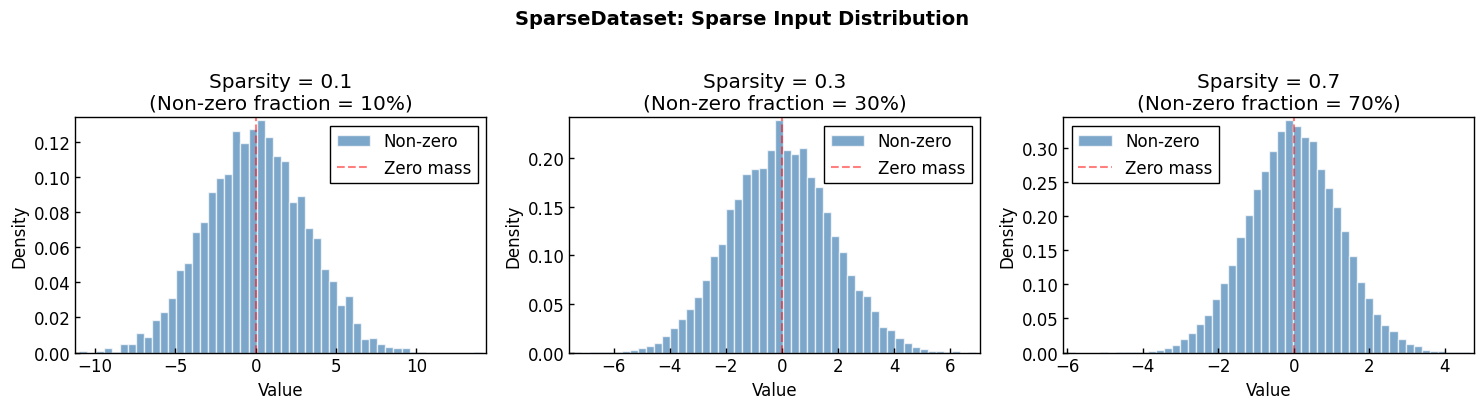

In [6]:
from statphys.dataset import SparseDataset

# Create dataset with different sparsity levels
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sparsities = [0.1, 0.3, 0.7]
for idx, sparsity in enumerate(sparsities):
    dataset = SparseDataset(d=100, sparsity=sparsity, rho=1.0, eta=0.1)
    X, y = dataset.generate_dataset(n_samples=500)
    
    ax = axes[idx]
    # Show histogram of non-zero values
    x_flat = X.numpy().flatten()
    ax.hist(x_flat[x_flat != 0], bins=50, density=True, alpha=0.7, 
           color='steelblue', edgecolor='white', label='Non-zero')
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Zero mass')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.set_title(f'Sparsity = {sparsity}\n(Non-zero fraction = {sparsity:.0%})')
    ax.legend()

fig.suptitle('SparseDataset: Sparse Input Distribution', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 2.2 BernoulliGaussianDataset

Dataset: BernoulliGaussianDataset
  - Bernoulli probability p: 0.2
  - Gaussian parameters: mu=0.0, sigma=1.0


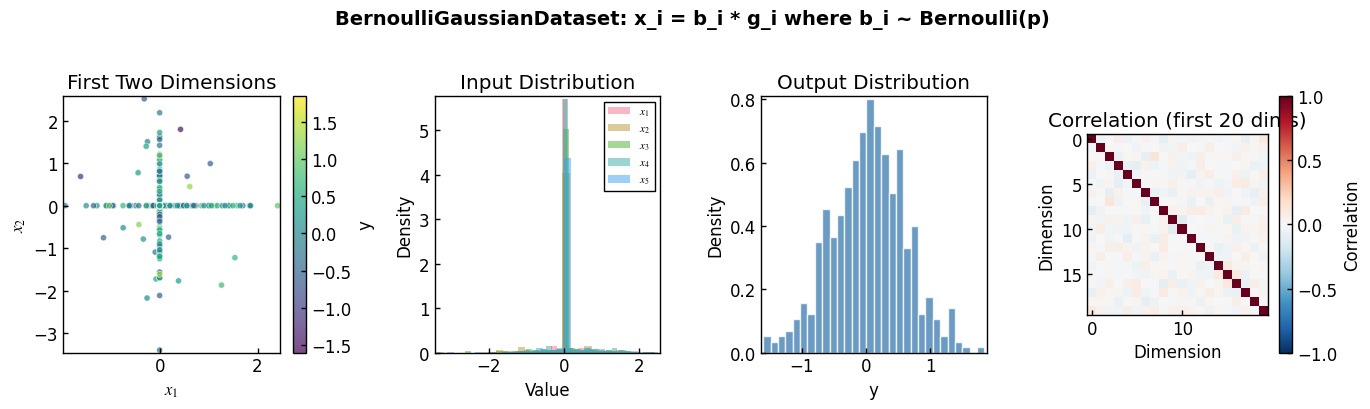

In [7]:
from statphys.dataset import BernoulliGaussianDataset

# Create dataset
dataset = BernoulliGaussianDataset(d=100, p=0.2, mu=0.0, sigma=1.0, rho=1.0, eta=0.1)
X, y = dataset.generate_dataset(n_samples=500)

print(f"Dataset: BernoulliGaussianDataset")
print(f"  - Bernoulli probability p: {dataset.p}")
print(f"  - Gaussian parameters: mu={dataset.mu}, sigma={dataset.sigma}")

plot_dataset_overview(X, y, "BernoulliGaussianDataset: x_i = b_i * g_i where b_i ~ Bernoulli(p)")
plt.show()

---

## 3. Structured Datasets

Datasets with non-trivial covariance structure.

### 3.1 CorrelatedGaussianDataset

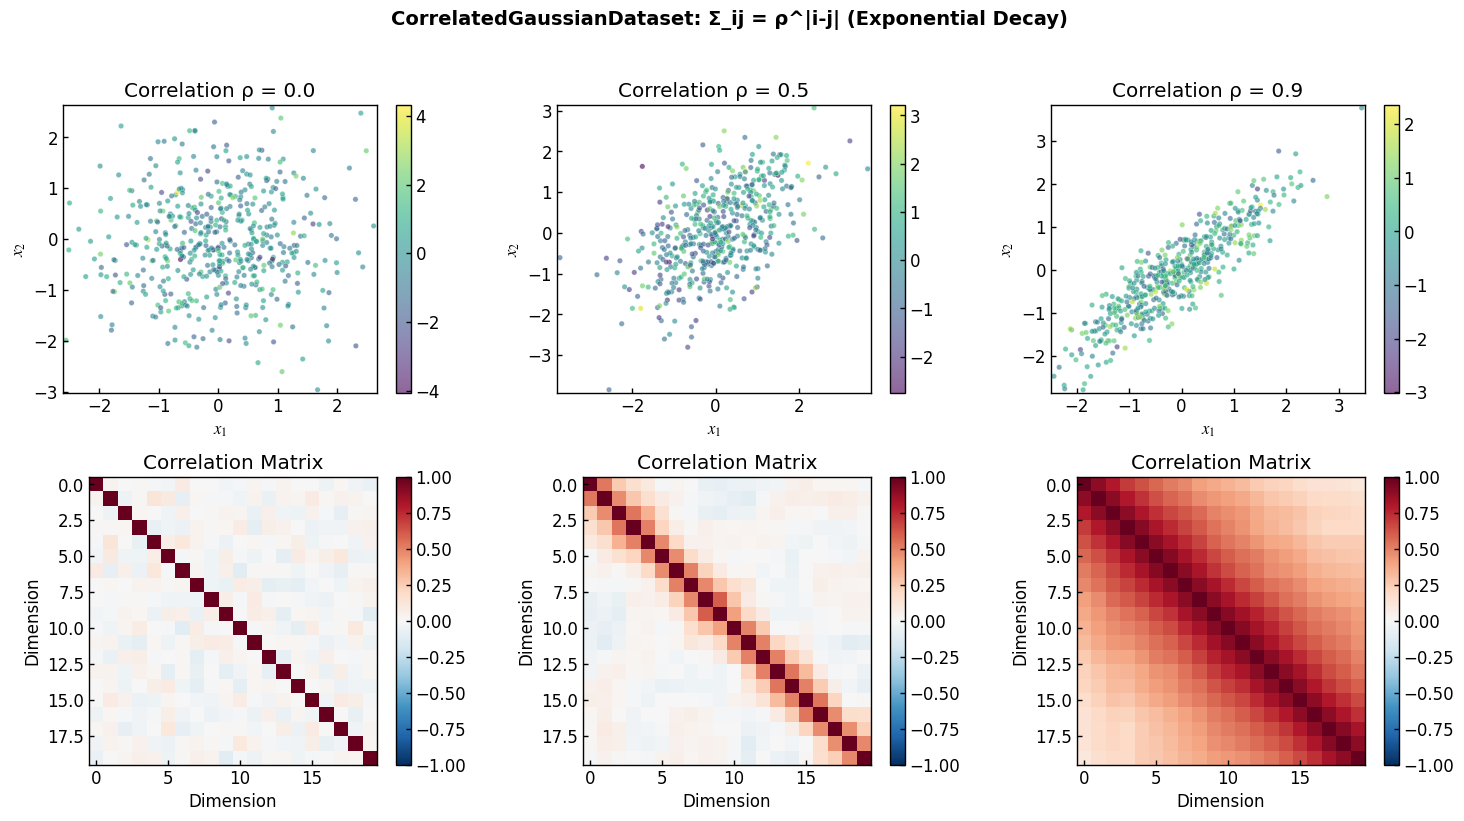

In [8]:
from statphys.dataset import CorrelatedGaussianDataset

# Create datasets with different correlation levels
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

correlations = [0.0, 0.5, 0.9]
for idx, corr in enumerate(correlations):
    dataset = CorrelatedGaussianDataset(d=50, correlation=corr, teacher_rho=1.0, eta=0.1)
    X, y = dataset.generate_dataset(n_samples=500)
    
    # Top row: Scatter plot
    ax = axes[0, idx]
    scatter = ax.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=y.numpy(), 
                        cmap='viridis', alpha=0.6, s=15, edgecolors='white', linewidths=0.3)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(f'Correlation ρ = {corr}')
    plt.colorbar(scatter, ax=ax)
    
    # Bottom row: Correlation matrix
    ax = axes[1, idx]
    X_np = X.numpy()
    cov = np.corrcoef(X_np[:, :20].T)
    im = ax.imshow(cov, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_xlabel('Dimension')
    ax.set_ylabel('Dimension')
    ax.set_title(f'Correlation Matrix')
    plt.colorbar(im, ax=ax)

fig.suptitle('CorrelatedGaussianDataset: Σ_ij = ρ^|i-j| (Exponential Decay)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.2 SpikedCovarianceDataset

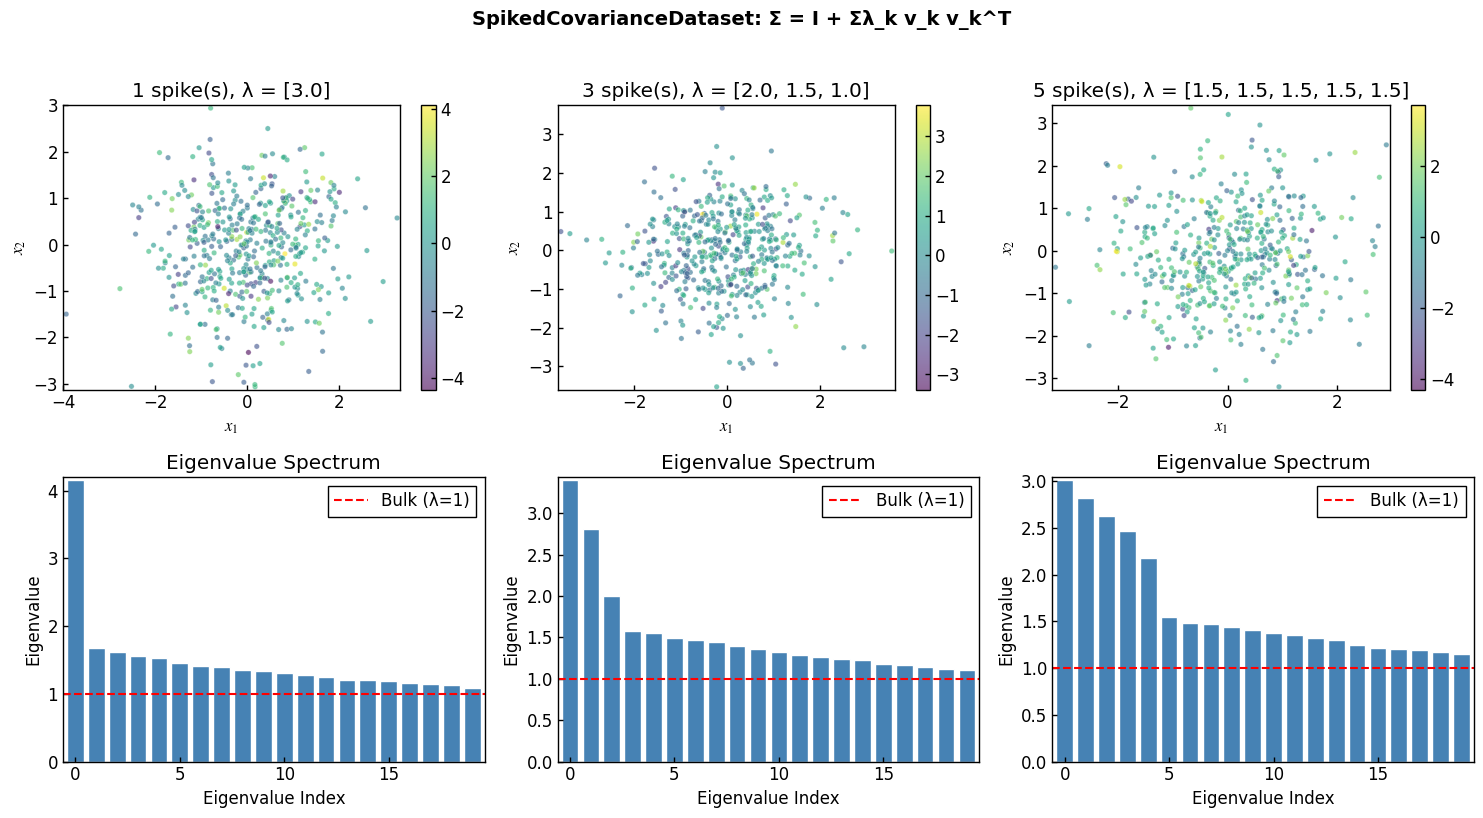

In [9]:
from statphys.dataset import SpikedCovarianceDataset

# Create datasets with different spike configurations
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

configs = [
    (1, [3.0]),      # Single strong spike
    (3, [2.0, 1.5, 1.0]),  # Multiple spikes
    (5, [1.5]*5),    # Many equal spikes
]

for idx, (n_spikes, strengths) in enumerate(configs):
    dataset = SpikedCovarianceDataset(d=50, n_spikes=n_spikes, spike_strengths=strengths, 
                                      rho=1.0, eta=0.1)
    X, y = dataset.generate_dataset(n_samples=500)
    
    # Top row: Scatter plot (first two principal components)
    ax = axes[0, idx]
    scatter = ax.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=y.numpy(), 
                        cmap='viridis', alpha=0.6, s=15, edgecolors='white', linewidths=0.3)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(f'{n_spikes} spike(s), λ = {strengths}')
    plt.colorbar(scatter, ax=ax)
    
    # Bottom row: Eigenvalue spectrum
    ax = axes[1, idx]
    X_np = X.numpy()
    cov_empirical = np.cov(X_np.T)
    eigvals = np.linalg.eigvalsh(cov_empirical)[::-1]  # Descending order
    ax.bar(range(min(20, len(eigvals))), eigvals[:20], color='steelblue', edgecolor='white')
    ax.axhline(y=1.0, color='red', linestyle='--', label='Bulk (λ=1)')
    ax.set_xlabel('Eigenvalue Index')
    ax.set_ylabel('Eigenvalue')
    ax.set_title('Eigenvalue Spectrum')
    ax.legend()

fig.suptitle('SpikedCovarianceDataset: Σ = I + Σλ_k v_k v_k^T', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## 4. GLM Teacher Datasets

Datasets with probabilistic label generation (Generalized Linear Models).

### 4.1 LogisticTeacherDataset

Dataset: LogisticTeacherDataset
  - P(y=1|u) = sigmoid(u) where u = w*^T x / sqrt(d)
  - Label distribution: +1: 228, -1: 272


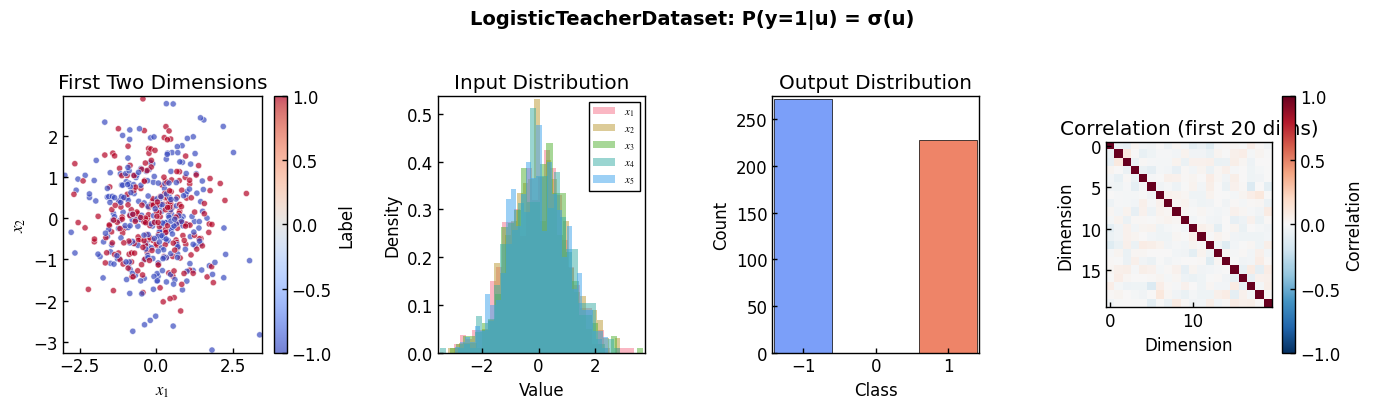

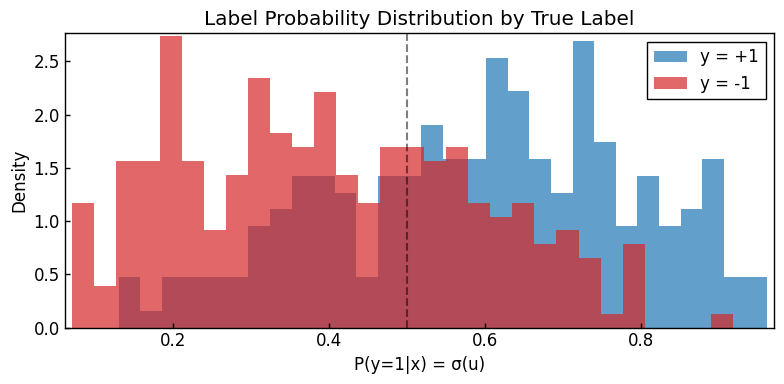

In [10]:
from statphys.dataset import LogisticTeacherDataset

# Create dataset
dataset = LogisticTeacherDataset(d=100, rho=1.0)
X, y = dataset.generate_dataset(n_samples=500)

print(f"Dataset: LogisticTeacherDataset")
print(f"  - P(y=1|u) = sigmoid(u) where u = w*^T x / sqrt(d)")
print(f"  - Label distribution: +1: {(y == 1).sum().item()}, -1: {(y == -1).sum().item()}")

plot_dataset_overview(X, y, "LogisticTeacherDataset: P(y=1|u) = σ(u)")
plt.show()

# Show probability distribution
fig, ax = plt.subplots(figsize=(8, 4))
teacher_w = dataset.get_teacher_params()['W0']
u = (X @ teacher_w / np.sqrt(dataset.d)).squeeze()
prob = torch.sigmoid(u)

ax.hist(prob[y == 1].numpy(), bins=30, alpha=0.7, label='y = +1', color='tab:blue', density=True)
ax.hist(prob[y == -1].numpy(), bins=30, alpha=0.7, label='y = -1', color='tab:red', density=True)
ax.set_xlabel('P(y=1|x) = σ(u)')
ax.set_ylabel('Density')
ax.set_title('Label Probability Distribution by True Label')
ax.legend()
ax.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 4.2 ProbitTeacherDataset

Dataset: ProbitTeacherDataset
  - P(y=1|u) = Φ(u) (Gaussian CDF)
  - Label distribution: +1: 251, -1: 249


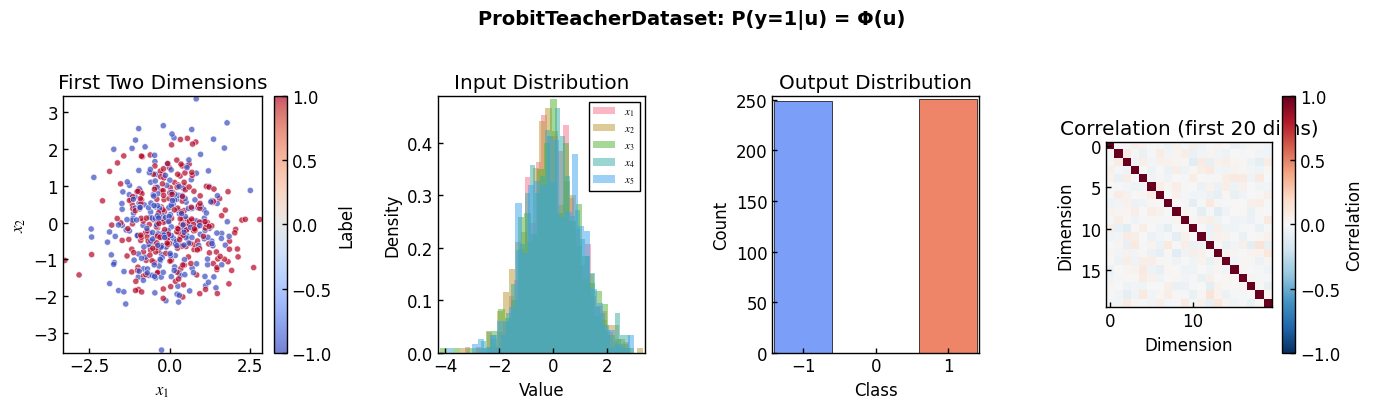

In [11]:
from statphys.dataset import ProbitTeacherDataset

# Create dataset
dataset = ProbitTeacherDataset(d=100, rho=1.0)
X, y = dataset.generate_dataset(n_samples=500)

print(f"Dataset: ProbitTeacherDataset")
print(f"  - P(y=1|u) = Φ(u) (Gaussian CDF)")
print(f"  - Label distribution: +1: {(y == 1).sum().item()}, -1: {(y == -1).sum().item()}")

plot_dataset_overview(X, y, "ProbitTeacherDataset: P(y=1|u) = Φ(u)")
plt.show()

### 4.3 Comparison: Logistic vs Probit

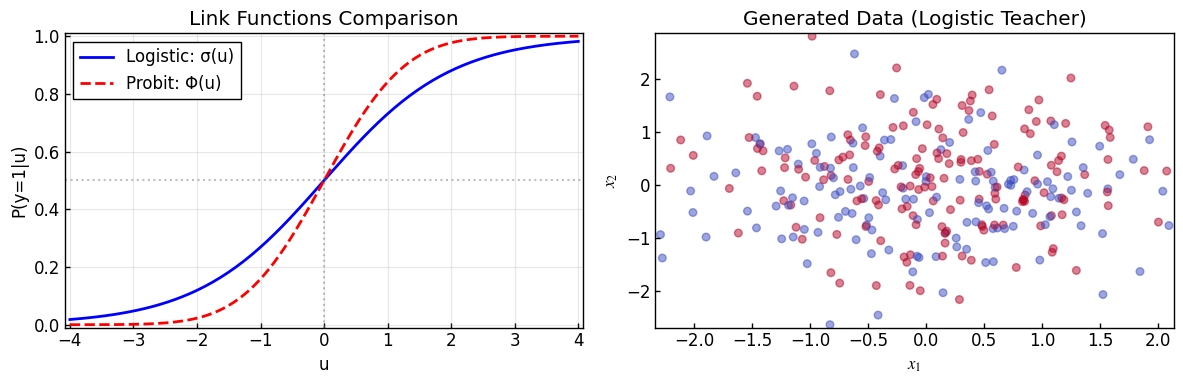

In [12]:
from scipy.stats import norm

# Compare logistic and probit link functions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

x = np.linspace(-4, 4, 200)
sigmoid = 1 / (1 + np.exp(-x))
probit = norm.cdf(x)

# Link functions
ax = axes[0]
ax.plot(x, sigmoid, 'b-', linewidth=2, label='Logistic: σ(u)')
ax.plot(x, probit, 'r--', linewidth=2, label='Probit: Φ(u)')
ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
ax.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('u')
ax.set_ylabel('P(y=1|u)')
ax.set_title('Link Functions Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Dataset comparison
ax = axes[1]
statphys.fix_seed(42)  # Same seed for both
logistic_data = LogisticTeacherDataset(d=100, rho=1.0)
statphys.fix_seed(42)
probit_data = ProbitTeacherDataset(d=100, rho=1.0)

X_log, y_log = logistic_data.generate_dataset(n_samples=300)
statphys.fix_seed(42)
X_pro, y_pro = probit_data.generate_dataset(n_samples=300)

ax.scatter(X_log[:, 0].numpy(), X_log[:, 1].numpy(), c=y_log.numpy(), 
          cmap='coolwarm', alpha=0.5, s=30, marker='o', label='Logistic')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Generated Data (Logistic Teacher)')

plt.tight_layout()
plt.show()

---

## 5. Gaussian Mixture Datasets

Datasets for DMFT/SGD analysis with clustered structure.

### 5.1 GaussianMixtureDataset (Binary)

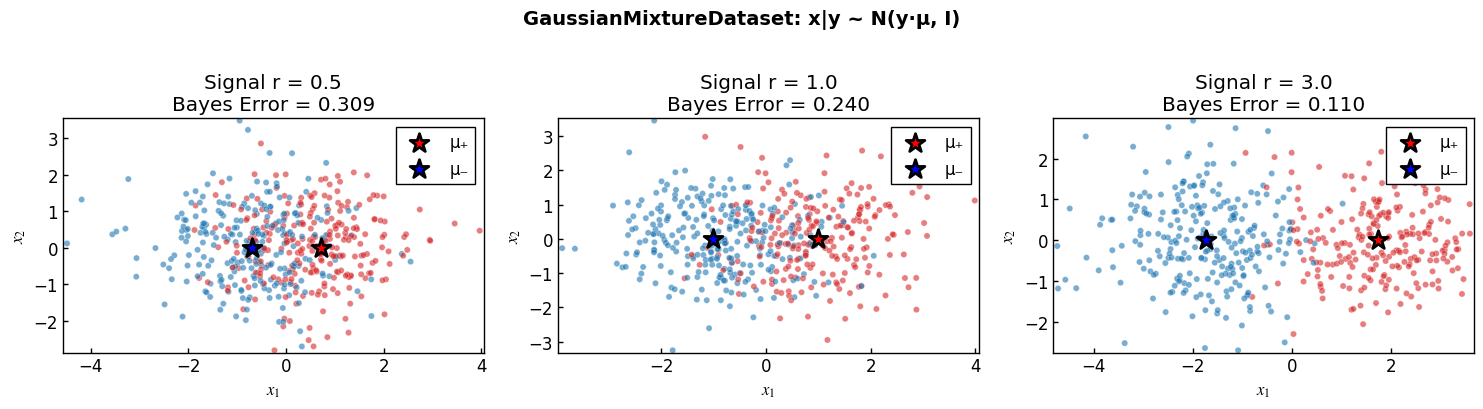

In [13]:
from statphys.dataset import GaussianMixtureDataset

# Create datasets with different signal strengths
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

signals = [0.5, 1.0, 3.0]
for idx, signal in enumerate(signals):
    dataset = GaussianMixtureDataset(d=100, signal=signal)
    X, y = dataset.generate_dataset(n_samples=500)
    
    ax = axes[idx]
    colors = ['tab:blue' if yi == -1 else 'tab:red' for yi in y.numpy()]
    ax.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=colors, alpha=0.6, s=20, 
              edgecolors='white', linewidths=0.3)
    
    # Mark class centers
    mu = dataset.mu.numpy()
    ax.scatter([mu[0]/np.sqrt(dataset.d)], [mu[1]/np.sqrt(dataset.d)], 
              c='red', s=200, marker='*', edgecolors='black', linewidths=2, label='μ₊')
    ax.scatter([-mu[0]/np.sqrt(dataset.d)], [-mu[1]/np.sqrt(dataset.d)], 
              c='blue', s=200, marker='*', edgecolors='black', linewidths=2, label='μ₋')
    
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    bayes_err = dataset.get_bayes_optimal_error()
    ax.set_title(f'Signal r = {signal}\nBayes Error = {bayes_err:.3f}')
    ax.legend(loc='upper right')

fig.suptitle('GaussianMixtureDataset: x|y ~ N(y·μ, I)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 5.2 MulticlassGaussianMixtureDataset

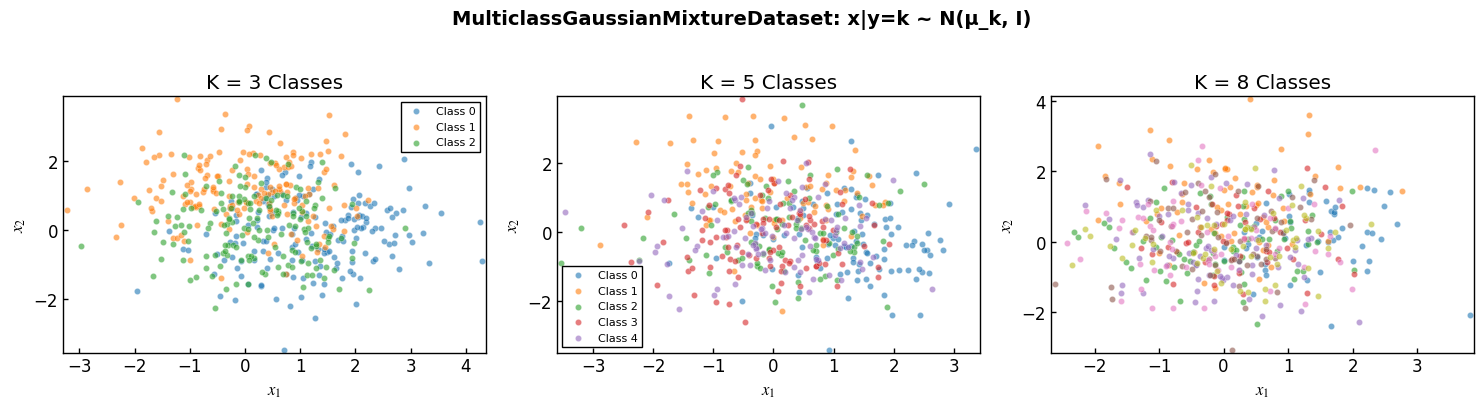

In [14]:
from statphys.dataset import MulticlassGaussianMixtureDataset

# Create datasets with different number of classes
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

class_configs = [3, 5, 8]
colors_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
               'tab:brown', 'tab:pink', 'tab:olive']

for idx, n_classes in enumerate(class_configs):
    dataset = MulticlassGaussianMixtureDataset(d=100, n_classes=n_classes, signal=1.5)
    X, y = dataset.generate_dataset(n_samples=500)
    
    ax = axes[idx]
    
    # Plot each class
    for k in range(n_classes):
        mask = (y == k).numpy()
        ax.scatter(X[mask, 0].numpy(), X[mask, 1].numpy(), 
                  c=[colors_list[k % len(colors_list)]], alpha=0.6, s=20,
                  edgecolors='white', linewidths=0.3, label=f'Class {k}')
    
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(f'K = {n_classes} Classes')
    if n_classes <= 5:
        ax.legend(loc='best', fontsize=8)

fig.suptitle('MulticlassGaussianMixtureDataset: x|y=k ~ N(μ_k, I)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. In-Context Learning (ICL) Datasets

Datasets for studying in-context learning in transformers.

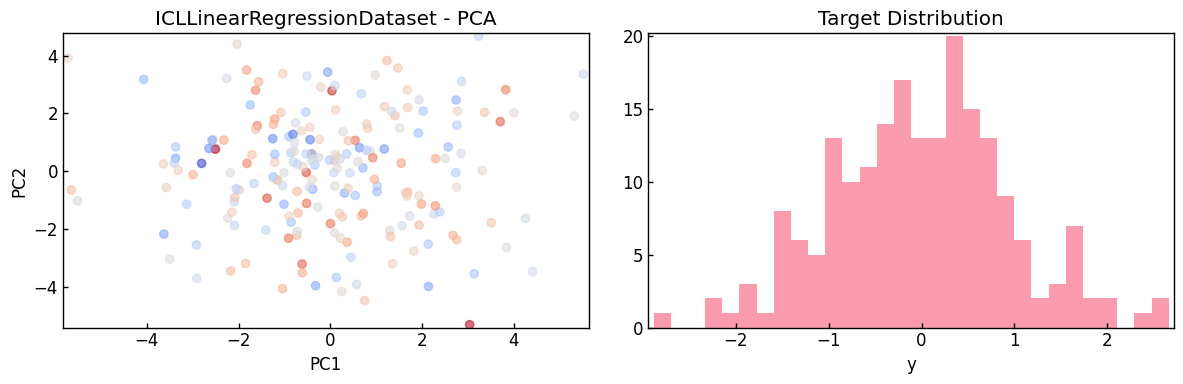

X shape: torch.Size([200, 220]), y shape: torch.Size([200])


In [15]:
# 6.1 ICLLinearRegressionDataset
from statphys.dataset import ICLLinearRegressionDataset
from sklearn.decomposition import PCA

icl_linear = ICLLinearRegressionDataset(d=20, context_len=10, noise_std=0.1)
X, y = icl_linear.generate_dataset(n_samples=200)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.detach().numpy())
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y.detach().numpy(), cmap='coolwarm', alpha=0.6)
axes[0].set_title('ICLLinearRegressionDataset - PCA')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[1].hist(y.detach().numpy(), bins=30, alpha=0.7)
axes[1].set_title('Target Distribution')
axes[1].set_xlabel('y')
plt.tight_layout()
plt.show()
print(f'X shape: {X.shape}, y shape: {y.shape}')

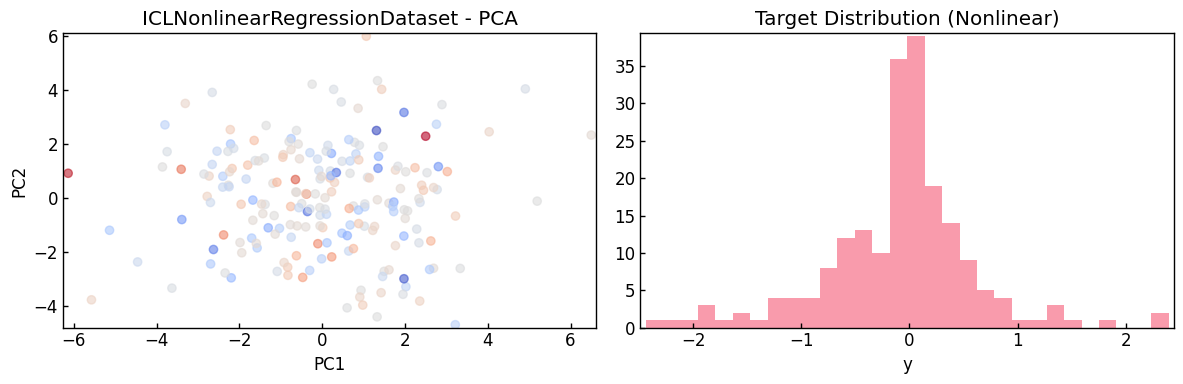

In [16]:
# 6.2 ICLNonlinearRegressionDataset
from statphys.dataset import ICLNonlinearRegressionDataset

icl_nonlinear = ICLNonlinearRegressionDataset(d=20, k=3, context_len=10, noise_std=0.1)
X, y = icl_nonlinear.generate_dataset(n_samples=200)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.detach().numpy())
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y.detach().numpy(), cmap='coolwarm', alpha=0.6)
axes[0].set_title('ICLNonlinearRegressionDataset - PCA')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[1].hist(y.detach().numpy(), bins=30, alpha=0.7)
axes[1].set_title('Target Distribution (Nonlinear)')
axes[1].set_xlabel('y')
plt.tight_layout()
plt.show()

## 7. Sequence/Token Datasets

Datasets for sequence modeling and token-based tasks.

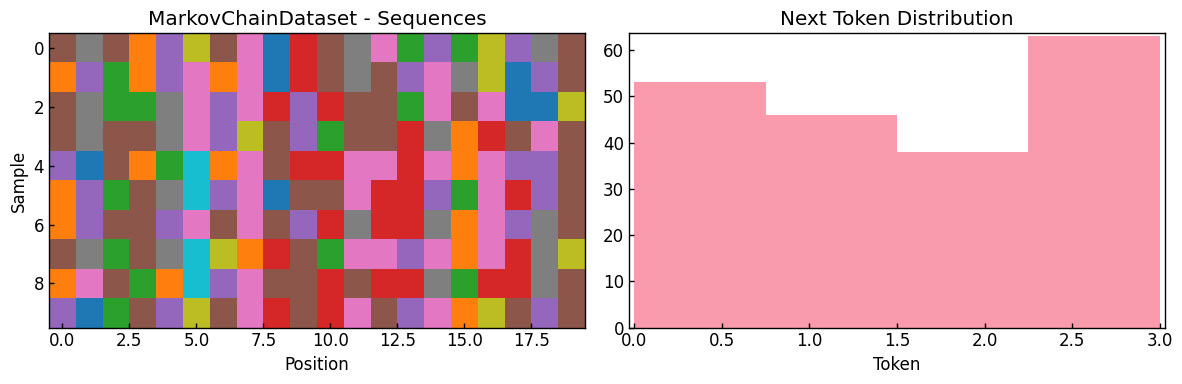

X shape: torch.Size([200, 380]), y shape: torch.Size([200])


In [17]:
# 7.1 MarkovChainDataset
from statphys.dataset import MarkovChainDataset

markov = MarkovChainDataset(d=20, n_states=4, seq_len=20)
X, y = markov.generate_dataset(n_samples=200)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Show first 10 samples as heatmap (reshape to seq_len x d)
X_reshaped = X[:10].detach().numpy().reshape(10, 20, -1)[:, :, 0]  # Take first feature
axes[0].imshow(X_reshaped, aspect='auto', cmap='tab10')
axes[0].set_title('MarkovChainDataset - Sequences')
axes[0].set_xlabel('Position')
axes[0].set_ylabel('Sample')
axes[1].hist(y.detach().numpy(), bins=4, alpha=0.7)
axes[1].set_title('Next Token Distribution')
axes[1].set_xlabel('Token')
plt.tight_layout()
plt.show()
print(f'X shape: {X.shape}, y shape: {y.shape}')

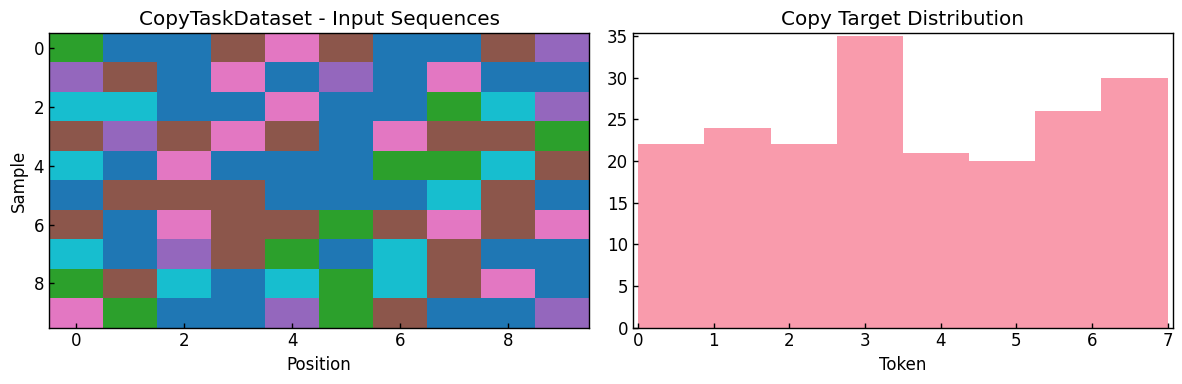

In [18]:
# 7.2 CopyTaskDataset
from statphys.dataset import CopyTaskDataset

copy_task = CopyTaskDataset(d=10, vocab_size=8, seq_len=10)
X, y = copy_task.generate_dataset(n_samples=200)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Show first 10 samples as heatmap
X_reshaped = X[:10].detach().numpy().reshape(10, 10, -1)[:, :, 0]
axes[0].imshow(X_reshaped, aspect='auto', cmap='tab10')
axes[0].set_title('CopyTaskDataset - Input Sequences')
axes[0].set_xlabel('Position')
axes[0].set_ylabel('Sample')
axes[1].hist(y.detach().numpy(), bins=8, alpha=0.7)
axes[1].set_title('Copy Target Distribution')
axes[1].set_xlabel('Token')
plt.tight_layout()
plt.show()

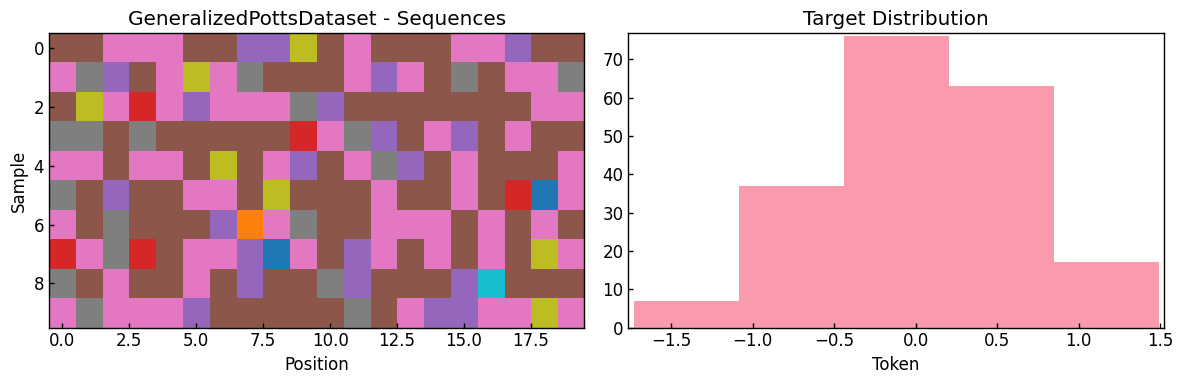

In [19]:
# 7.3 GeneralizedPottsDataset
from statphys.dataset import GeneralizedPottsDataset

potts = GeneralizedPottsDataset(d=20, seq_len=20, vocab_size=5, coupling_strength=2.0)
X, y = potts.generate_dataset(n_samples=200)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
X_reshaped = X[:10].detach().numpy().reshape(10, 20, -1)[:, :, 0]
axes[0].imshow(X_reshaped, aspect='auto', cmap='tab10')
axes[0].set_title('GeneralizedPottsDataset - Sequences')
axes[0].set_xlabel('Position')
axes[0].set_ylabel('Sample')
axes[1].hist(y.detach().numpy(), bins=5, alpha=0.7)
axes[1].set_title('Target Distribution')
axes[1].set_xlabel('Token')
plt.tight_layout()
plt.show()

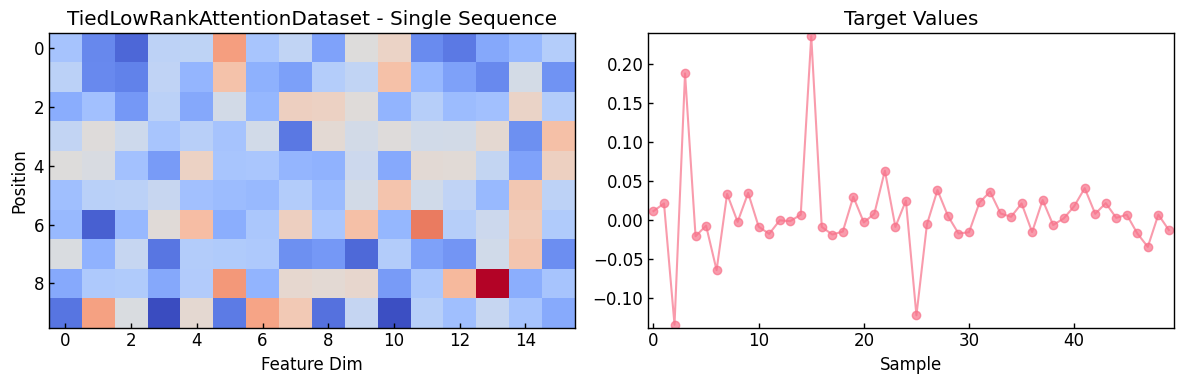

X shape: torch.Size([200, 160]), y shape: torch.Size([200, 160])


In [20]:
# 7.4 TiedLowRankAttentionDataset
from statphys.dataset import TiedLowRankAttentionDataset

tlra = TiedLowRankAttentionDataset(d=16, seq_len=10, teacher_rank=4)
X, y = tlra.generate_dataset(n_samples=200)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Reshape X to (n_samples, seq_len, d)
X_reshaped = X[:10].detach().numpy().reshape(10, 10, 16)
axes[0].imshow(X_reshaped[0], aspect='auto', cmap='coolwarm')
axes[0].set_title('TiedLowRankAttentionDataset - Single Sequence')
axes[0].set_xlabel('Feature Dim')
axes[0].set_ylabel('Position')
# y is also (n_samples, seq_len * d)
y_flat = y[:50, 0].detach().numpy() if y.dim() > 1 else y[:50].detach().numpy()
axes[1].plot(y_flat, 'o-', alpha=0.7)
axes[1].set_title('Target Values')
axes[1].set_xlabel('Sample')
plt.tight_layout()
plt.show()
print(f'X shape: {X.shape}, y shape: {y.shape}')

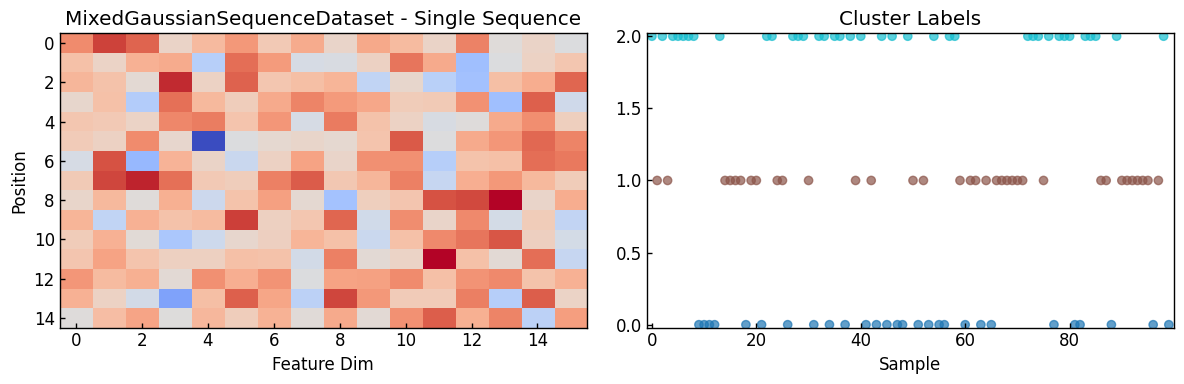

In [21]:
# 7.5 MixedGaussianSequenceDataset
from statphys.dataset import MixedGaussianSequenceDataset

mixed_seq = MixedGaussianSequenceDataset(d=16, seq_len=15, n_clusters=3)
X, y = mixed_seq.generate_dataset(n_samples=200)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
X_reshaped = X[:10].detach().numpy().reshape(10, 15, 16)
axes[0].imshow(X_reshaped[0], aspect='auto', cmap='coolwarm')
axes[0].set_title('MixedGaussianSequenceDataset - Single Sequence')
axes[0].set_xlabel('Feature Dim')
axes[0].set_ylabel('Position')
y_np = y.detach().numpy()
axes[1].scatter(range(len(y_np[:100])), y_np[:100], c=y_np[:100], cmap='tab10', alpha=0.7)
axes[1].set_title('Cluster Labels')
axes[1].set_xlabel('Sample')
plt.tight_layout()
plt.show()

## 8. Attention-Indexed Datasets

Datasets for attention-indexed model (AIM) analysis.

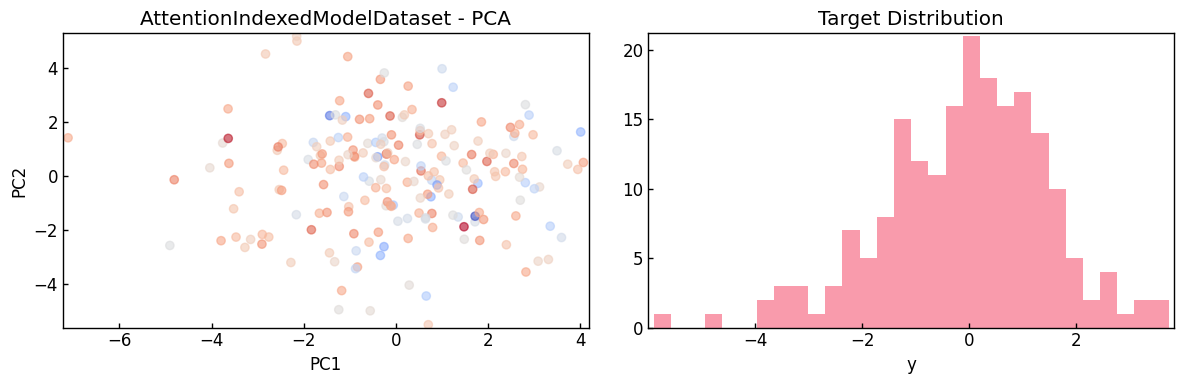

X shape: torch.Size([200, 200]), y shape: torch.Size([200])


In [22]:
# 8.1 AttentionIndexedModelDataset
from statphys.dataset import AttentionIndexedModelDataset

aim = AttentionIndexedModelDataset(d=20, n_tokens=10, n_indices=2)
X, y = aim.generate_dataset(n_samples=200)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.detach().numpy())
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y.detach().numpy(), cmap='coolwarm', alpha=0.6)
axes[0].set_title('AttentionIndexedModelDataset - PCA')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[1].hist(y.detach().numpy(), bins=30, alpha=0.7)
axes[1].set_title('Target Distribution')
axes[1].set_xlabel('y')
plt.tight_layout()
plt.show()
print(f'X shape: {X.shape}, y shape: {y.shape}')

## 9. Fairness/Bias Datasets

Datasets for studying fairness and bias in machine learning.

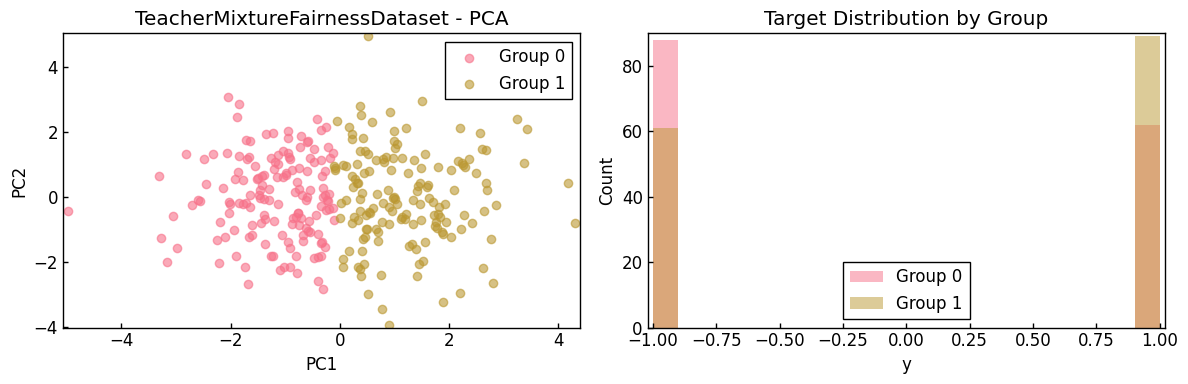

In [23]:
# 9.1 TeacherMixtureFairnessDataset
from statphys.dataset import TeacherMixtureFairnessDataset

fairness = TeacherMixtureFairnessDataset(d=50, group_ratio=0.3)
X, y = fairness.generate_dataset(n_samples=300)

# Create synthetic group labels based on first principal component
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.detach().numpy())
group_labels = (X_pca[:, 0] > np.median(X_pca[:, 0])).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for g in [0, 1]:
    mask = group_labels == g
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], label=f'Group {g}', alpha=0.6)
axes[0].set_title('TeacherMixtureFairnessDataset - PCA')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend()

for g in [0, 1]:
    mask = group_labels == g
    axes[1].hist(y[mask].detach().numpy(), alpha=0.5, label=f'Group {g}', bins=20)
axes[1].set_title('Target Distribution by Group')
axes[1].set_xlabel('y')
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
plt.show()

## 10. Noisy Label Datasets

Datasets for studying learning with noisy labels.

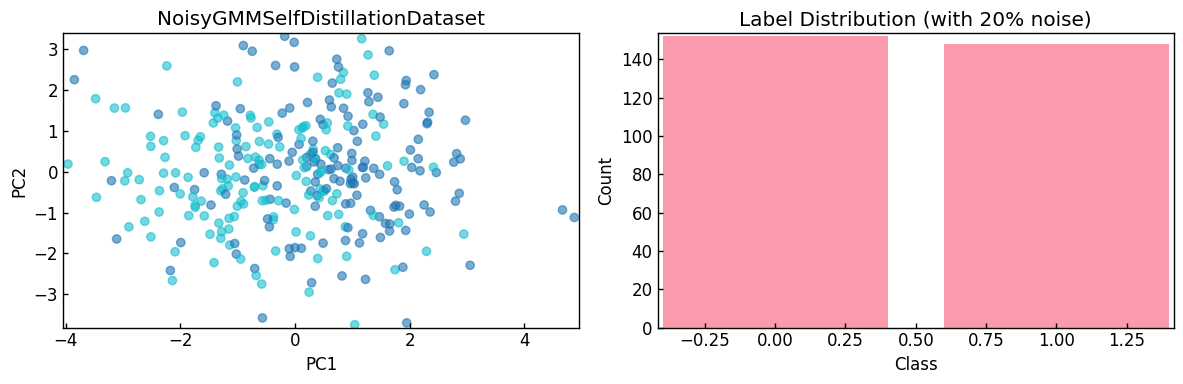

X shape: torch.Size([300, 50]), y shape: torch.Size([300])


In [24]:
# 10.1 NoisyGMMSelfDistillationDataset
from statphys.dataset import NoisyGMMSelfDistillationDataset

noisy = NoisyGMMSelfDistillationDataset(d=50, label_noise=0.2)
X, y = noisy.generate_dataset(n_samples=300)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.detach().numpy())

y_np = y.detach().numpy()
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_np, cmap='tab10', alpha=0.6)
axes[0].set_title('NoisyGMMSelfDistillationDataset')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

unique_labels = np.unique(y_np)
axes[1].bar(unique_labels, [np.sum(y_np == l) for l in unique_labels], alpha=0.7)
axes[1].set_title('Label Distribution (with 20% noise)')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()
print(f'X shape: {X.shape}, y shape: {y.shape}')

## Summary: All 22 Datasets

Creating a summary visualization of all datasets.

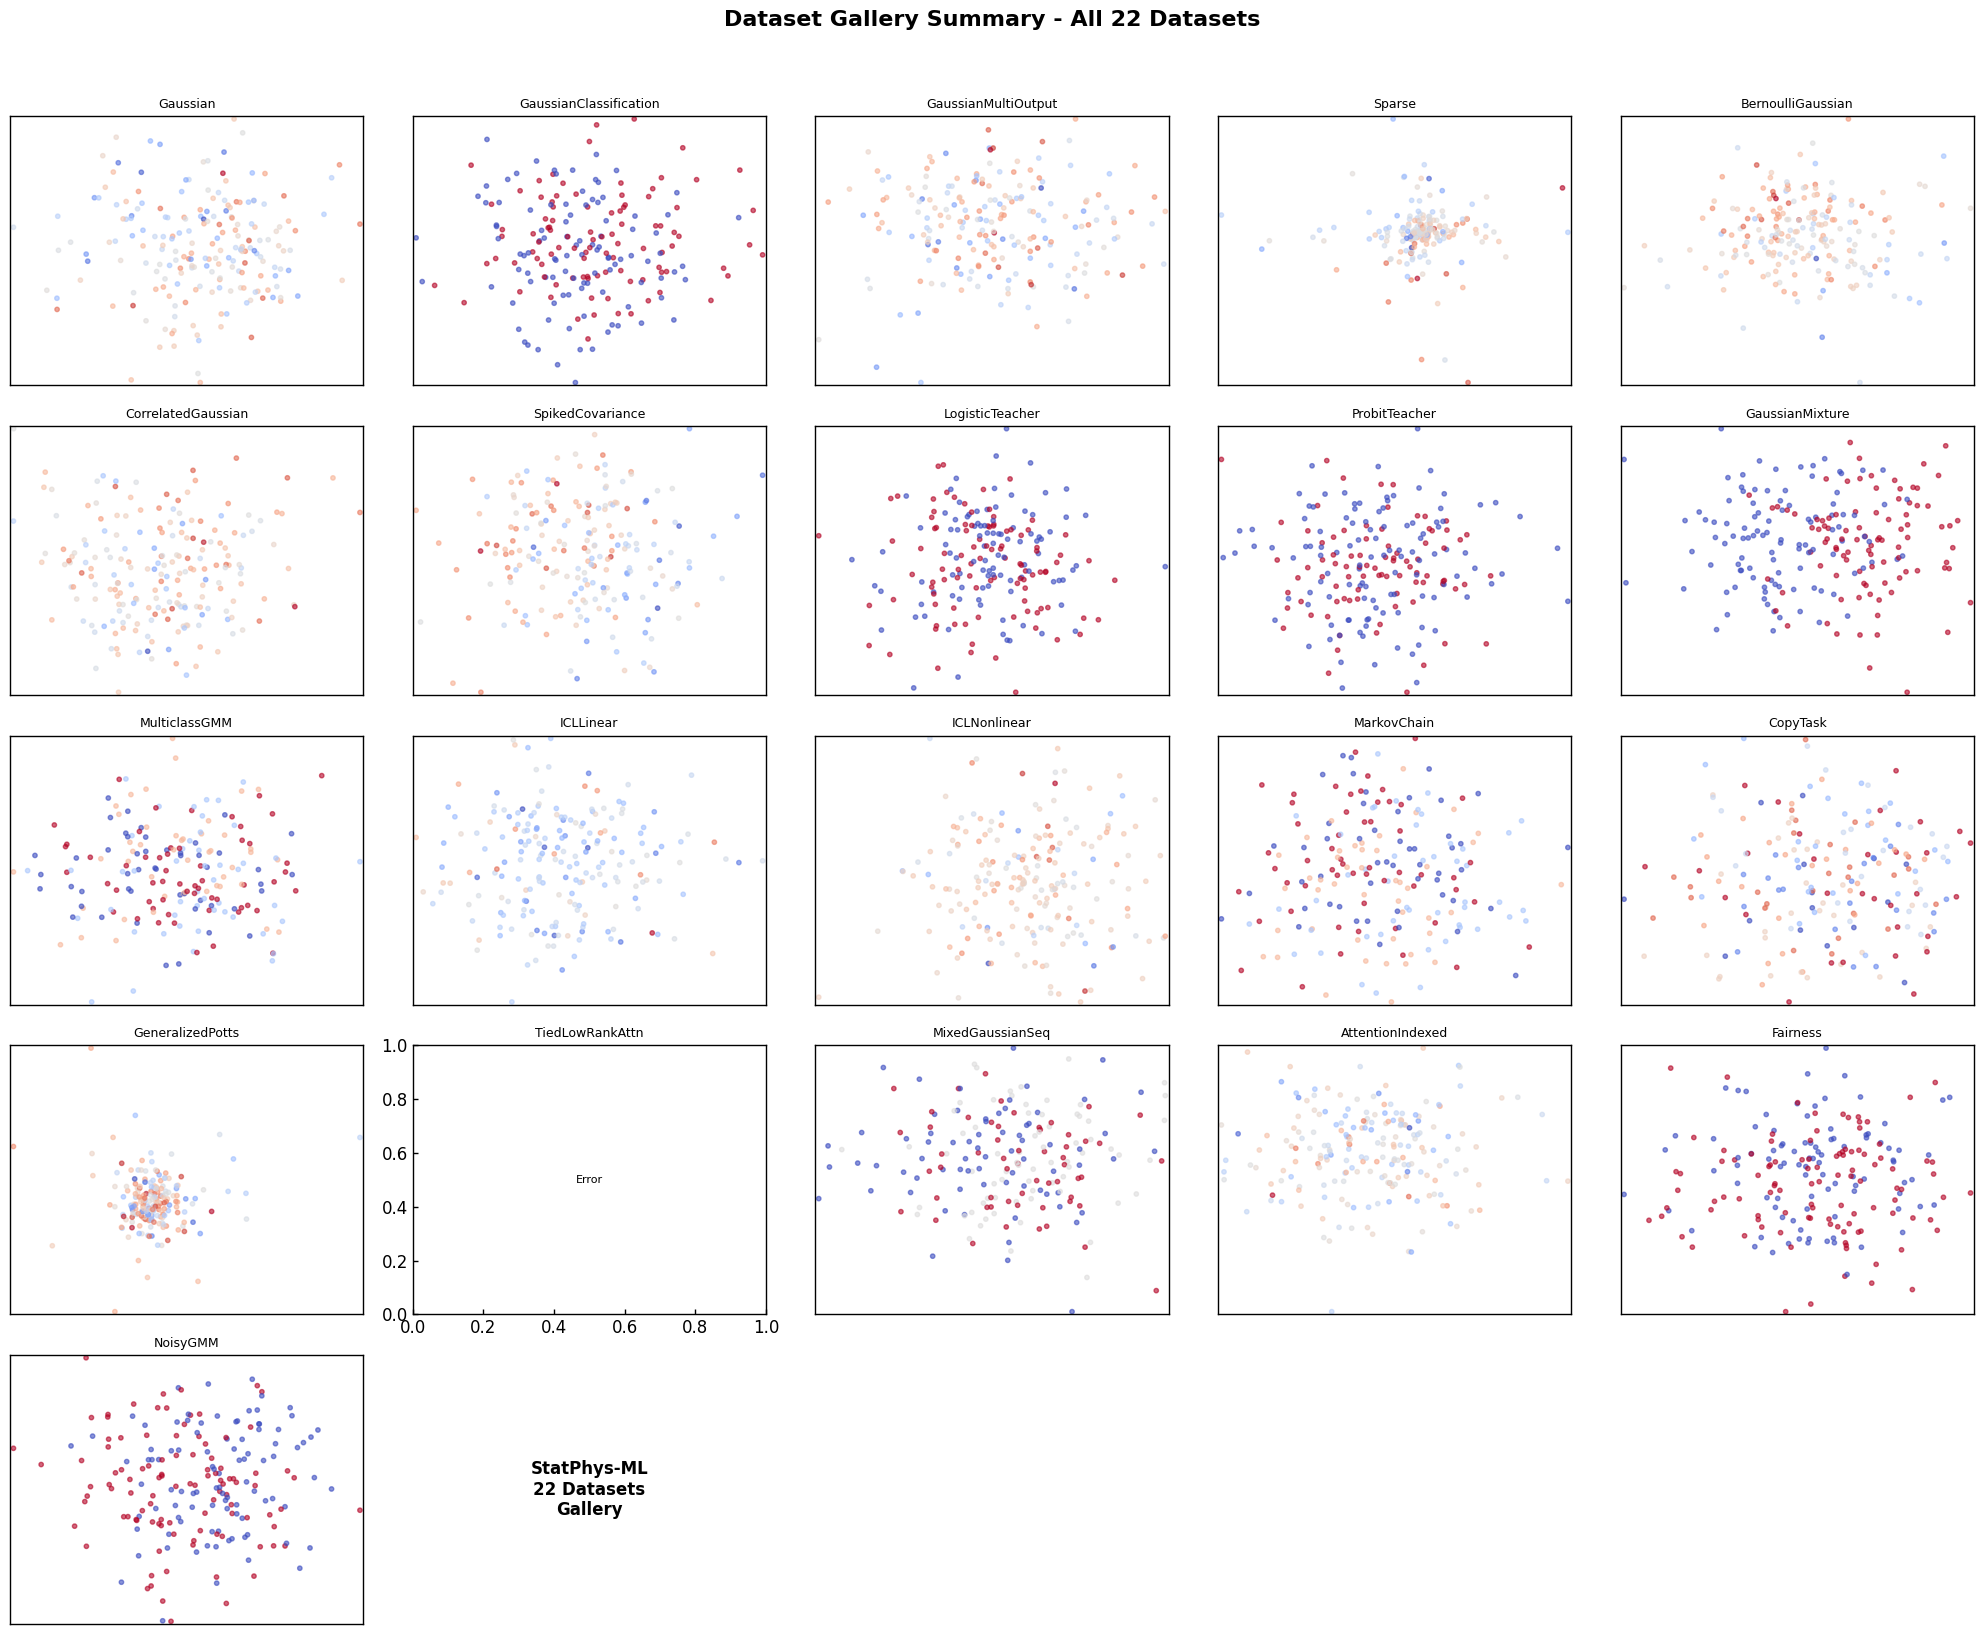

Summary saved to dataset_gallery_summary.png


In [25]:
# Create summary visualization of all datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

fig, axes = plt.subplots(5, 5, figsize=(20, 16))
axes = axes.flatten()

from statphys.dataset import (
    GaussianDataset, GaussianClassificationDataset, GaussianMultiOutputDataset,
    SparseDataset, BernoulliGaussianDataset,
    CorrelatedGaussianDataset, SpikedCovarianceDataset,
    LogisticTeacherDataset, ProbitTeacherDataset,
    GaussianMixtureDataset, MulticlassGaussianMixtureDataset,
    ICLLinearRegressionDataset, ICLNonlinearRegressionDataset,
    MarkovChainDataset, CopyTaskDataset, GeneralizedPottsDataset,
    TiedLowRankAttentionDataset, MixedGaussianSequenceDataset,
    AttentionIndexedModelDataset,
    TeacherMixtureFairnessDataset,
    NoisyGMMSelfDistillationDataset,
)

datasets_list = [
    ('Gaussian', lambda: GaussianDataset(d=50, rho=1.0, eta=0.1)),
    ('GaussianClassification', lambda: GaussianClassificationDataset(d=50)),
    ('GaussianMultiOutput', lambda: GaussianMultiOutputDataset(d=50, k=3)),
    ('Sparse', lambda: SparseDataset(d=50, sparsity=0.1)),
    ('BernoulliGaussian', lambda: BernoulliGaussianDataset(d=50, p=0.3)),
    ('CorrelatedGaussian', lambda: CorrelatedGaussianDataset(d=50, correlation=0.5)),
    ('SpikedCovariance', lambda: SpikedCovarianceDataset(d=50, spike_strength=2.0)),
    ('LogisticTeacher', lambda: LogisticTeacherDataset(d=50)),
    ('ProbitTeacher', lambda: ProbitTeacherDataset(d=50)),
    ('GaussianMixture', lambda: GaussianMixtureDataset(d=50, n_classes=2)),
    ('MulticlassGMM', lambda: MulticlassGaussianMixtureDataset(d=50, n_classes=4)),
    ('ICLLinear', lambda: ICLLinearRegressionDataset(d=20, context_len=10)),
    ('ICLNonlinear', lambda: ICLNonlinearRegressionDataset(d=20, k=3, context_len=10)),
    ('MarkovChain', lambda: MarkovChainDataset(d=20, n_states=4, seq_len=20)),
    ('CopyTask', lambda: CopyTaskDataset(d=10, vocab_size=8, seq_len=10)),
    ('GeneralizedPotts', lambda: GeneralizedPottsDataset(d=20, seq_len=20, vocab_size=5, coupling_strength=2.0)),
    ('TiedLowRankAttn', lambda: TiedLowRankAttentionDataset(d=16, seq_len=10, teacher_rank=4)),
    ('MixedGaussianSeq', lambda: MixedGaussianSequenceDataset(d=16, seq_len=15, n_clusters=3)),
    ('AttentionIndexed', lambda: AttentionIndexedModelDataset(d=20, n_tokens=10, n_indices=2)),
    ('Fairness', lambda: TeacherMixtureFairnessDataset(d=50, group_ratio=0.3)),
    ('NoisyGMM', lambda: NoisyGMMSelfDistillationDataset(d=50, label_noise=0.2)),
]

for i, (name, create_ds) in enumerate(datasets_list):
    ax = axes[i]
    try:
        ds = create_ds()
        X, y = ds.generate_dataset(n_samples=200)
        
        # PCA visualization for all datasets
        if X.shape[1] > 2:
            pca = PCA(n_components=2)
            X_vis = pca.fit_transform(X.detach().numpy())
        else:
            X_vis = X.detach().numpy()
        
        y_np = y.detach().numpy().flatten()
        scatter = ax.scatter(X_vis[:, 0], X_vis[:, 1], c=y_np, cmap='coolwarm', alpha=0.6, s=10)
        ax.set_title(name, fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])
        
    except Exception as e:
        ax.text(0.5, 0.5, f'Error', ha='center', va='center', fontsize=8)
        ax.set_title(name, fontsize=9)

# Hide unused axes and add summary text
for i in range(len(datasets_list), len(axes)):
    axes[i].axis('off')

axes[21].text(0.5, 0.5, 'StatPhys-ML\n22 Datasets\nGallery', ha='center', va='center', fontsize=12, fontweight='bold')
axes[22].axis('off')
axes[23].axis('off')
axes[24].axis('off')

plt.suptitle('Dataset Gallery Summary - All 22 Datasets', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('dataset_gallery_summary.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print('Summary saved to dataset_gallery_summary.png')
